In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,
                                   LabelEncoder,
                                   MinMaxScaler)
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             classification_report,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay,
                             DetCurveDisplay)
from sklearn.tree import plot_tree



def load_data():
    url = 'https://raw.githubusercontent.com/rfordatascience/' + \
    'tidytuesday/master/data/2020/2020-07-07/coffee_ratings.csv'
    df = pd.read_csv(url)
    df_interim = df.copy()
    df_interim = df_interim[['total_cup_points',
                                'species',
                                'country_of_origin',
                                'variety',
                                'aroma',
                                'aftertaste',
                                'acidity',
                                'body',
                                'balance',
                                'altitude_mean_meters', 'moisture']]
    df_interim = df_interim.dropna()
    df_interim["species"] = pd.Categorical(df_interim["species"])
    df_interim["country_of_origin"] = pd.Categorical(df_interim["country_of_origin"])
    df_interim["variety"] = pd.Categorical(df_interim["variety"])
    df_interim["specialty"] = df_interim["total_cup_points"].apply(lambda x: "yes" if x>82.43 else "no")
    df_interim["altitude"] = df_interim["altitude_mean_meters"].apply(lambda x:1300 if x > 1000 else x)
    df_interim["specialty"] = pd.Categorical(df_interim["specialty"])
    df_interim = df_interim[df_interim["acidity"]!=0].copy()
    df_interim = df_interim[df_interim["altitude_mean_meters"]<=10000].copy()
    df_interim = df_interim.drop('total_cup_points', axis=1)
    df = df_interim.copy()
    return df
df_ch = load_data()
df_ch




,species,country_of_origin,variety,aroma,aftertaste,acidity,body,balance,altitude_mean_meters,moisture,specialty,altitude
1,Arabica,Ethiopia,Other,8.75,8.50,8.58,8.42,8.42,2075.00,0.12,yes,1300.0
2,Arabica,Guatemala,Bourbon,8.42,8.42,8.42,8.33,8.42,1700.00,0.00,yes,1300.0
4,Arabica,Ethiopia,Other,8.25,8.25,8.50,8.42,8.33,2075.00,0.12,yes,1300.0
9,Arabica,Ethiopia,Other,8.08,8.50,8.50,7.67,8.42,1822.50,0.10,yes,1300.0
11,Arabica,United States,Other,8.25,8.17,8.33,8.08,8.17,1872.00,0.00,yes,1300.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,Arabica,Nicaragua,Caturra,7.25,6.33,6.25,6.42,6.08,1100.00,0.13,no,1300.0
1309,Arabica,Guatemala,Catuai,7.50,6.67,7.67,7.33,6.67,1417.32,0.10,no,1300.0
1319,Robusta,India,Other,7.67,7.58,7.83,7.83,8.00,1000.00,0.09,yes,1000.0
1322,Robusta,India,Other,7.67,7.75,7.50,7.75,7.58,1000.00,0.11,no,1000.0


In [62]:
df_ch.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992 entries, 1 to 1333
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   species               992 non-null    category
 1   country_of_origin     992 non-null    category
 2   variety               992 non-null    category
 3   aroma                 992 non-null    float64 
 4   aftertaste            992 non-null    float64 
 5   acidity               992 non-null    float64 
 6   body                  992 non-null    float64 
 7   balance               992 non-null    float64 
 8   altitude_mean_meters  992 non-null    float64 
 9   moisture              992 non-null    float64 
 10  specialty             992 non-null    category
 11  altitude              992 non-null    float64 
dtypes: category(4), float64(8)
memory usage: 76.4 KB


In [63]:

df_ch.drop(["species","country_of_origin","variety"], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
aroma,992.0,7.567490,0.301464,5.08,7.42,7.58,7.75,8.75
aftertaste,992.0,7.384345,0.330149,6.17,7.17,7.42,7.58,8.58
acidity,992.0,7.522127,0.302747,5.25,7.33,7.50,7.67,8.58
body,992.0,7.504083,0.270352,6.33,7.33,7.50,7.67,8.42
balance,992.0,7.499607,0.339855,6.08,7.33,7.50,7.67,8.58
altitude_mean_meters,992.0,1323.841626,471.893958,1.00,1100.00,1310.64,1600.00,4287.00
moisture,992.0,0.093710,0.044411,0.00,0.10,0.11,0.12,0.17
altitude,992.0,1179.186310,286.870978,1.00,1300.00,1300.00,1300.00,1300.00


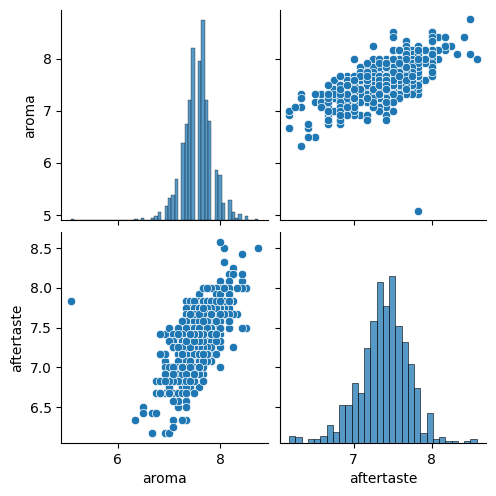

In [64]:
sns.pairplot(data = df_ch[["aroma","aftertaste"]])
plt.show()

In [65]:
df = (
    df_ch
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_ch.columns.to_list() if c not in ['target']]
        )
    )
)

In [66]:
df_train, df_test = train_test_split(df_ch, 
                                     random_state=2024, 
                                     test_size=0.20, 
                                     stratify=df_ch['specialty'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, 936 to 382
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   species               793 non-null    category
 1   country_of_origin     793 non-null    category
 2   variety               793 non-null    category
 3   aroma                 793 non-null    float64 
 4   aftertaste            793 non-null    float64 
 5   acidity               793 non-null    float64 
 6   body                  793 non-null    float64 
 7   balance               793 non-null    float64 
 8   altitude_mean_meters  793 non-null    float64 
 9   moisture              793 non-null    float64 
 10  specialty             793 non-null    category
 11  altitude              793 non-null    float64 
dtypes: category(4), float64(8)
memory usage: 61.7 KB


In [67]:
display(df_train.describe(include="number").T)
display(df_train.describe(include="category").T)

,count,mean,std,min,25%,50%,75%,max
aroma,793.0,7.564502,0.300148,5.08,7.42,7.58,7.75,8.75
aftertaste,793.0,7.384515,0.332563,6.17,7.17,7.42,7.58,8.58
acidity,793.0,7.518689,0.304674,5.25,7.33,7.50,7.67,8.58
body,793.0,7.509710,0.275964,6.33,7.33,7.50,7.67,8.42
balance,793.0,7.501627,0.345011,6.08,7.33,7.50,7.67,8.58
altitude_mean_meters,793.0,1316.453110,473.305511,1.00,1100.00,1310.64,1600.00,4287.00
moisture,793.0,0.093026,0.044884,0.00,0.10,0.11,0.12,0.17
altitude,793.0,1173.704833,292.710451,1.00,1300.00,1300.00,1300.00,1300.00


,count,unique,top,freq
species,793,2,Arabica,792
country_of_origin,793,30,Mexico,181
variety,793,27,Caturra,187
specialty,793,2,no,399


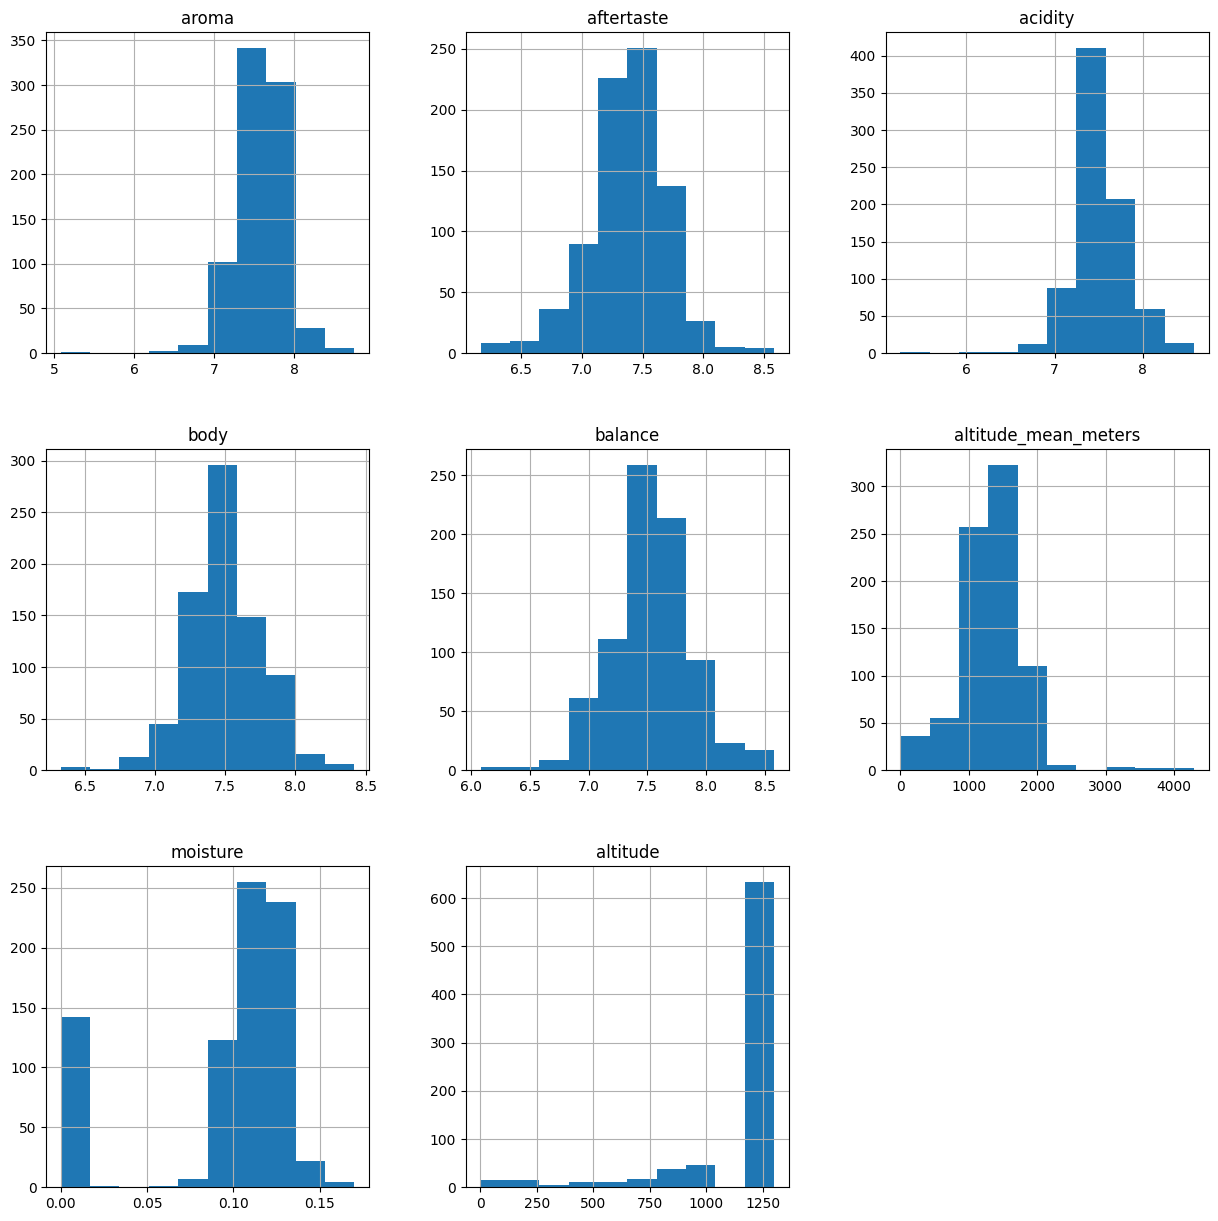

In [68]:
#Analisis univariado
df_train.hist(figsize=(15,15))
plt.show()

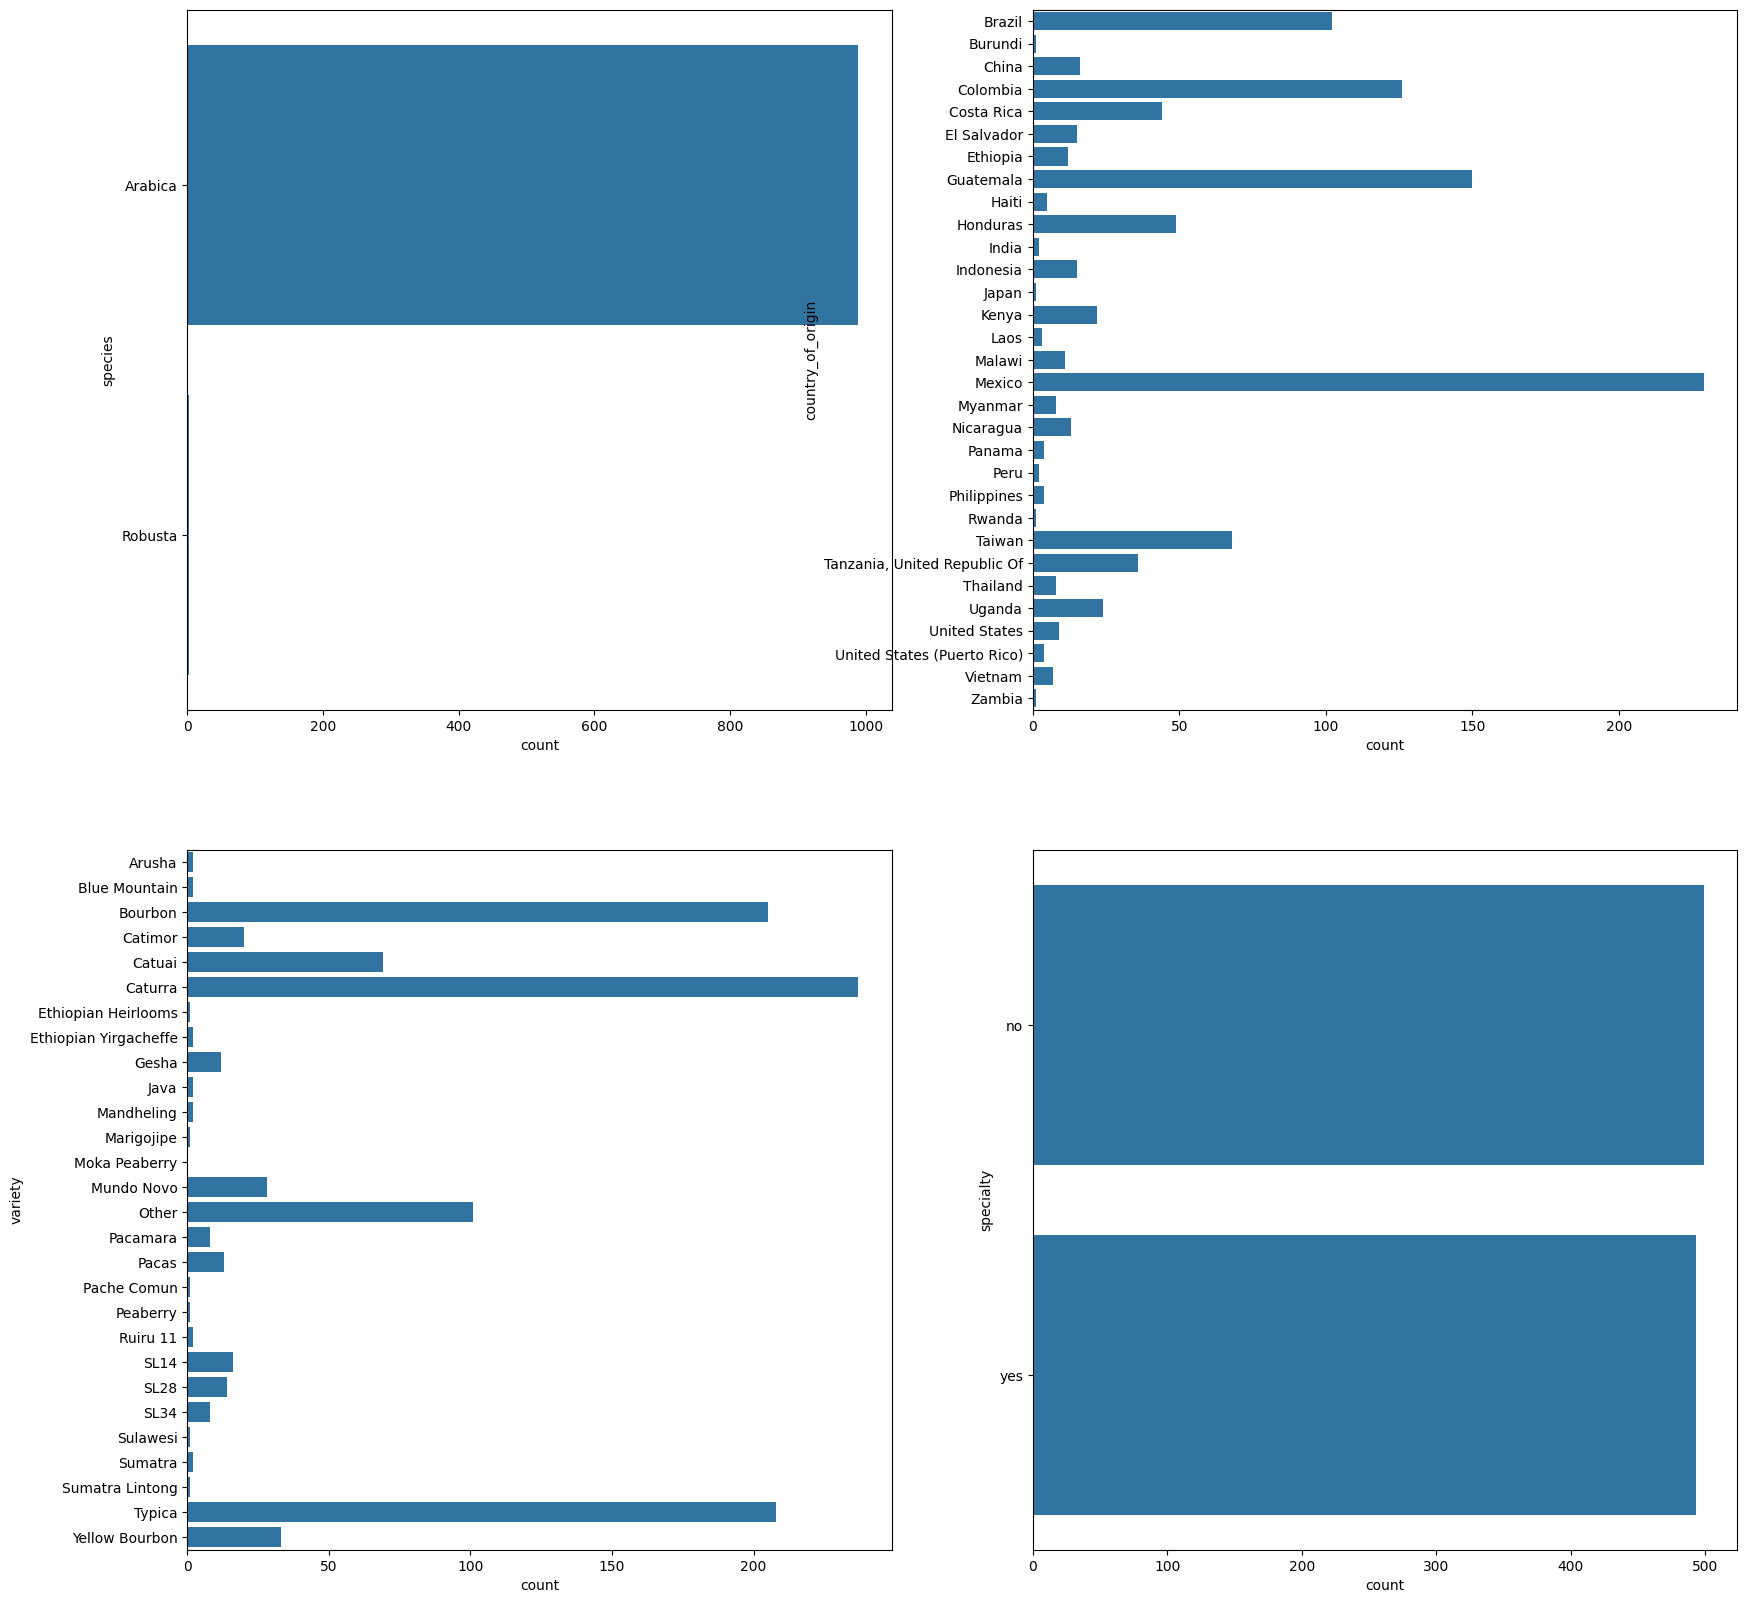

In [72]:
# Step 4 Univaried Analysis
fig, ax = plt.subplots(2, 2,  figsize= (20, 20))
sns.countplot(data= df, y= 'species', ax= ax[0, 0])
sns.countplot(data= df, y= 'country_of_origin', ax= ax[0, 1])
sns.countplot(data= df, y= 'variety', ax= ax[1, 0])
sns.countplot(data= df, y= 'specialty', ax= ax[1, 1])
#fig.delaxes(ax[2,1])
plt.show()

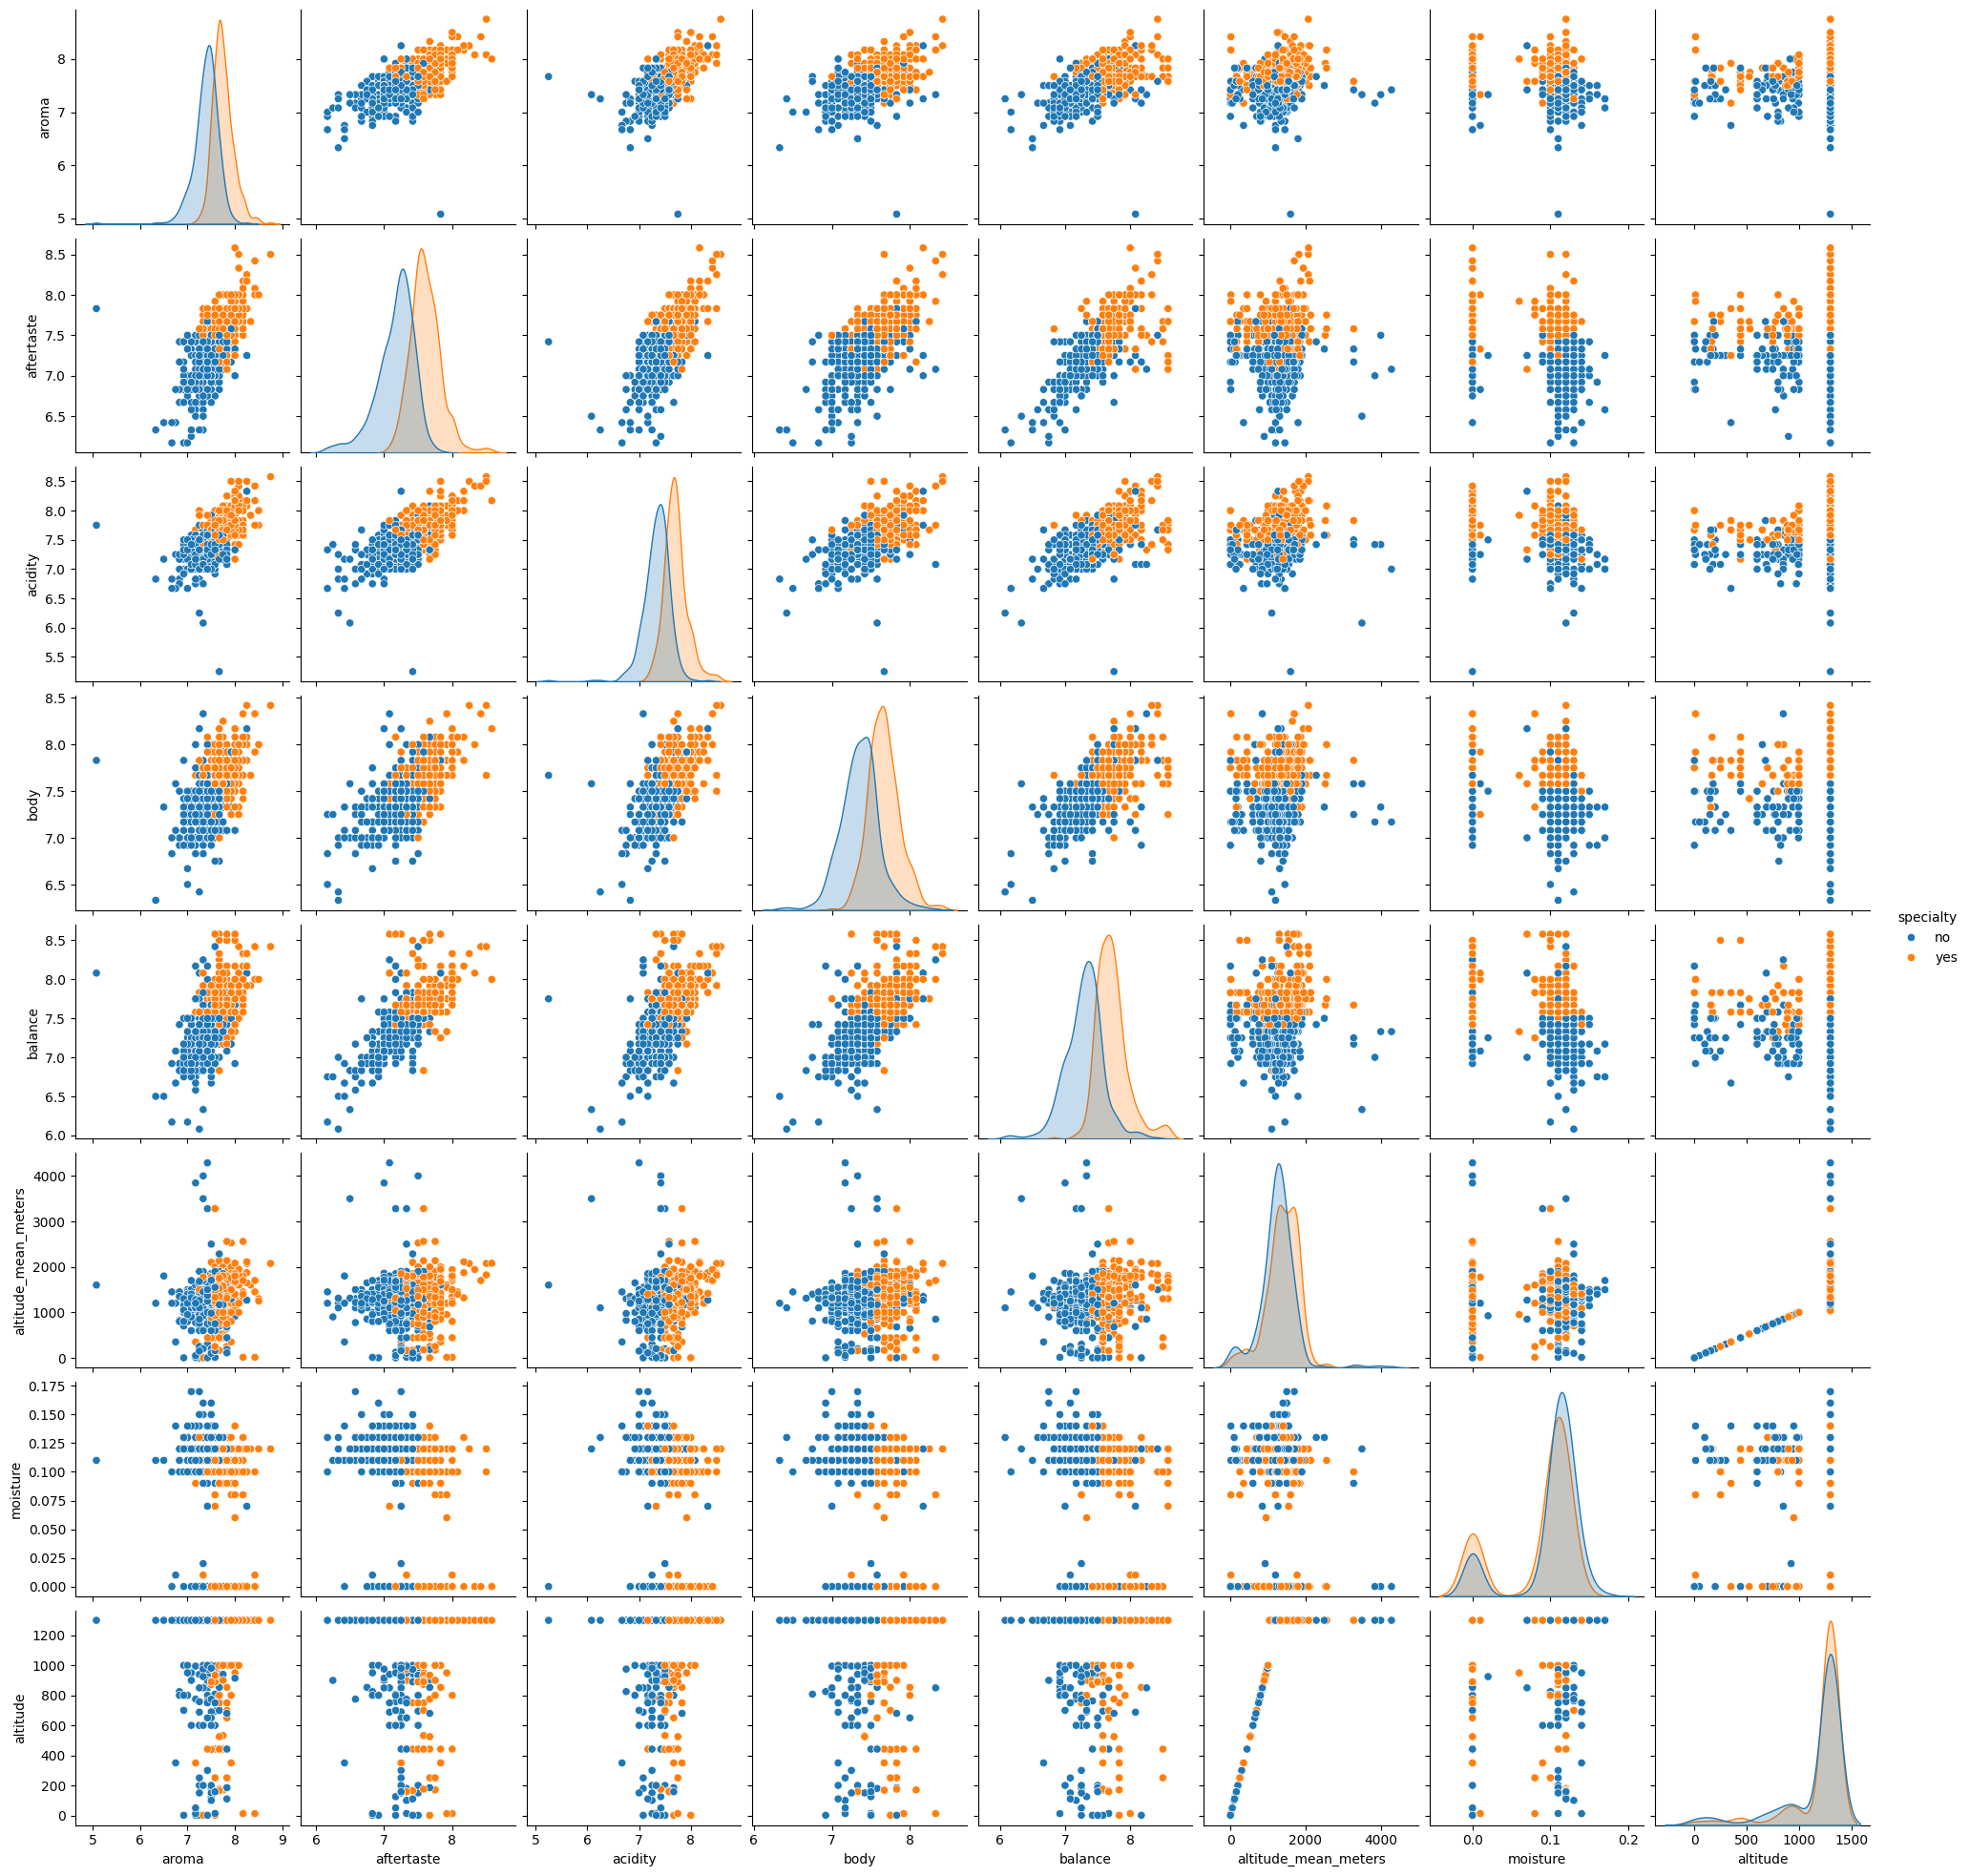

In [76]:
#analisis bivariado numerico
sns.pairplot(data=df_train, hue='specialty')
plt.show()

In [ ]:
#Analisis bivariado categorico 
fig, ax = plt.subplots()